# Gaussian processes with outliers

Suppose there are data distributed according a noisy Gaussian process with outliers at places.
Doing inference with outliers renders the inference useless, and is indeed where point-wise marginal likelihood maximisation falls flat on its face.
With JAXNS we can marginalise over hyper parameters as easily as defining them as prior RVs and marginalising over the posterior.

A Gaussian process is defined by a covariance function, $K : \mathcal{X} \times \mathcal{X} \to \mathbb{R}$, and a mean function $\mu : \mathcal{X} \to \mathbb{R}$.
Given the above data we see that it is equivalent to a Gaussian likelihood, with Gaussian process prior,

$L(x) = p(y | x) = \mathcal{N}[y \mid x, \Sigma]$

and

$p(x) = \mathcal{N}[x \mid \mu(X), K(X,X)]$

where $\mu(X)$ and $K(X,X)$ are the mean and covariance functions evaluated over the coordinate locations of the data.

The evidence of this model is well known,

$Z \triangleq p(y) = \int_\mathcal{X} L(x) p(x) \,\mathrm{d} x = \mathcal{N}[y \mid \mu(X), K(X,X) + \Sigma)$

and likewise the posterior distribution is,

$p(x \mid y) = \mathcal{N}[x \mid \mu', K']$

where

$\mu' = \mu(X) + K(X,X) (K(X,X) + \Sigma)^{-1}(y - \mu(X))$

and

$K' = K(X,X) - K(X,X) (K(X,X) + \Sigma)^{-1} K(X,X)$

## Marginalisation

The mean and covariance functions are not _a priori_ known and thus we must infer them as well.
Let the hyper parameters of the mean and covariance functions, and the noise covariance be $\theta$, and suppose we wish to infer their values.
The likelihood then becomes,

$p(y \mid \theta) = \int_\mathcal{X} L(x | \theta) p(x) p(\theta) \,\mathrm{d} x = \mathcal{N}[y \mid \mu_\theta(X), K_\theta(X,X) + \Sigma_\theta)$

where we recognise this as the marginal likelihood.

Now suppose we wish to predict $x$ at new points $X' \subset \mathcal{X}$, then this equivalent to sampling from the marginalised predictive posterior,

$$p(x(X') | y) = \int p(x(X') \mid x(X)) p(x(X) \mid y, \theta) p(y \mid \theta) p(\theta) \mathrm{d} \theta \mathrm{d} x(X)\\
= \mathbb{E}_{\theta \mid y}[p(x(X') \mid x(X)) p(x(X) \mid y, \theta) \mathrm{d} x(X)]$$

Now since $p(x(X') \mid x(X))$ and $p(x(X) \mid y, \theta)$ are both Gaussians, their product is also a Gaussian, and is given by,

$$p(x(X') \mid x(X)) p(x(X) \mid y, \theta) = \mathcal{N}[x(X') \mid K(X',X)K(X,X)^{-1} x(X), K(X',X') - K(X',X)K(X,X)^{-1}K(X,X')] \mathcal{N}[x(X) \mid \mu', K']\\
\implies \int p(x(X') \mid x(X)) p(x(X) \mid y, \theta) \mathrm{d} x(X) = \mathcal{N}[x(X') \mid m, S]$$

where

$m = K(X',X)K(X,X)^{-1} \mu'$

and

$S = K(X',X')  + K(X',X) (K(X,X)^{-1} K' K(X,X)^{-1} -  K(X,X)^{-1})K(X,X')$

Therefore, sampling from the marginalised predictive distribution is equivalent to sampling $\theta \sim p(\theta \mid y)$, and then sampling $x(X') \sim \mathcal{N}[x(X') \mid m, S]$.

In [1]:
# For Gaussian processes 64bit is important
from jax.config import config

config.update("jax_enable_x64", True)

import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions
tfpk = tfp.math.psd_kernels

from jaxns import marginalise_dynamic, ForcedIdentifiability, maximum_a_posteriori_point, evaluate_map_estimate
from jax.scipy.linalg import solve_triangular
from jax import random
from jax import numpy as jnp
import pylab as plt

INFO[2023-12-21 13:27:41,688]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-21 13:27:41,689]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-21 13:27:41,690]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-21 13:27:41,690]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


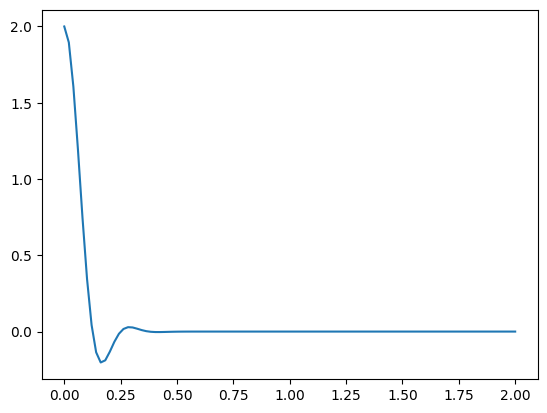

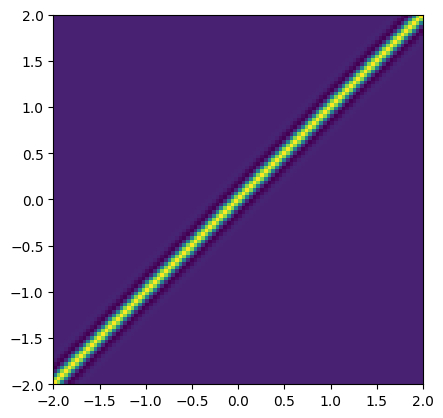

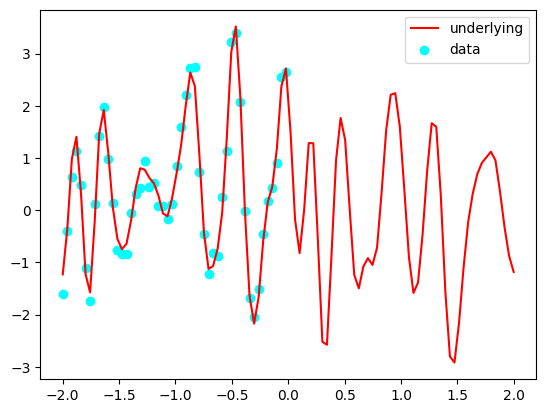

In [2]:
N = 100
M = N // 2
Xstar = jnp.linspace(-2., 2., N)[:, None]
X = Xstar[:M]

true_uncert = 0.2

spectral_params_true = dict(
    logits=jnp.asarray([0., 0.]),
    locs=jnp.asarray([1. / 1, 1. / 0.5]),
    scales=jnp.asarray([1. / 4., 1 / 0.8])
)
prior_cov = tfpk.SpectralMixture(**spectral_params_true).matrix(Xstar, Xstar) + 1e-12 * jnp.eye(N)

v = jnp.linspace(0., 2., 100)
kern = tfpk.SpectralMixture(**spectral_params_true).matrix(jnp.zeros((1, 1)), v[:, None])
plt.plot(v, kern[0, :])
plt.show()

plt.imshow(prior_cov, origin='lower', extent=(Xstar.min(), Xstar.max(), Xstar.min(), Xstar.max()))
plt.show()

Y = jnp.linalg.cholesky(prior_cov) @ random.normal(random.PRNGKey(42), shape=(N,))
Y_obs = Y[:M] + true_uncert * random.normal(random.PRNGKey(1), shape=(M,))
# Y = jnp.cos(jnp.pi*2. * X[:,0]/2) + jnp.exp(- X[:,0]/2) * jnp.sin(jnp.pi*2. * X[:,0]/3)


plt.plot(Xstar[:, 0], Y, c='red', label='underlying')
plt.scatter(X[:, 0], Y_obs, c='cyan', label='data')
plt.legend()
plt.show()


INFO[2023-12-21 13:27:45,178]: Sanity check...
INFO[2023-12-21 13:27:45,434]: Sanity check passed


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 238726
samples: 19320
phantom samples: 16170
likelihood evals / sample: 12.4
phantom fraction (%): 83.7%
--------
logZ=-54.0 +- 0.32
H=-4.69
ESS=720
--------
bandwidth[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
bandwidth[0]: 1.0 +- 0.43 | 0.63 / 0.94 / 1.34 | 1.34 | 1.31
bandwidth[1]: 1.5 +- 1.4 | 0.5 / 0.8 / 3.6 | 0.6 | 0.6
--------
locs[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
locs[0]: 2.42 +- 0.62 | 1.59 / 2.51 / 3.11 | 2.84 | 2.85
locs[1]: 1.12 +- 0.53 | 0.57 / 0.98 / 1.96 | 2.07 | 1.63
--------
logits[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
logits[0]: 0.22 +- 0.59 | -0.52 / 0.3 / 0.85 | -0.02 | 0.27
logits[1]: -0.27 +- 0.72 | -1.19 / -0.22 / 0.58 | -0.07 | -0.39
--------
period[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
period[0]: 0.46 +- 0.2 | 0.32 / 0.4 / 0.63 | 0.35 | 0.3

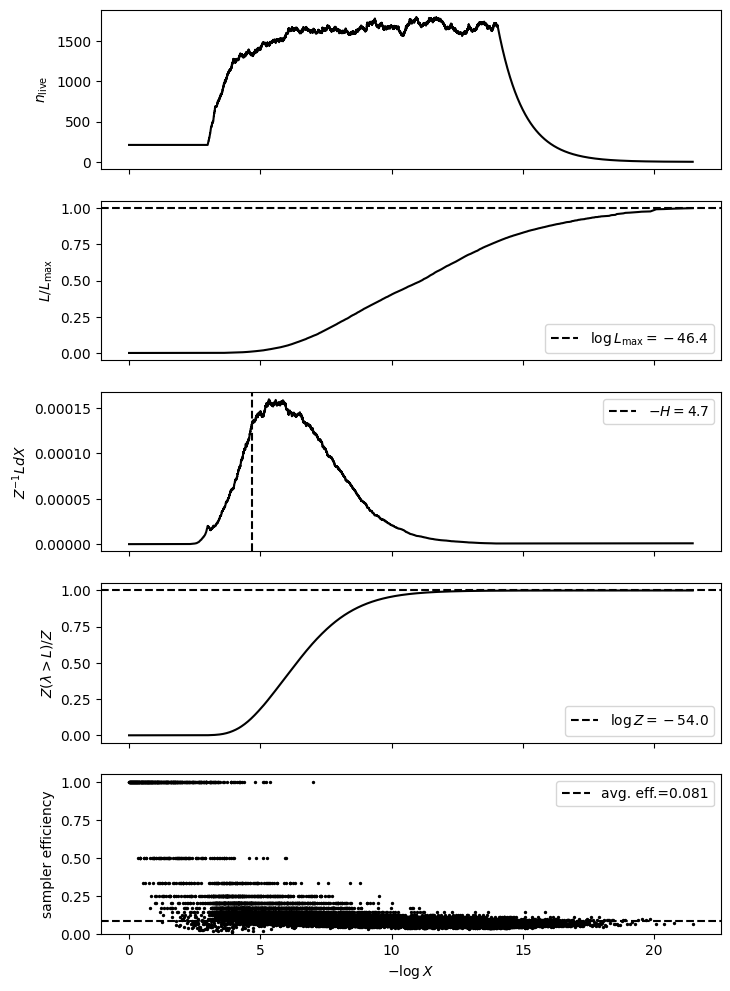

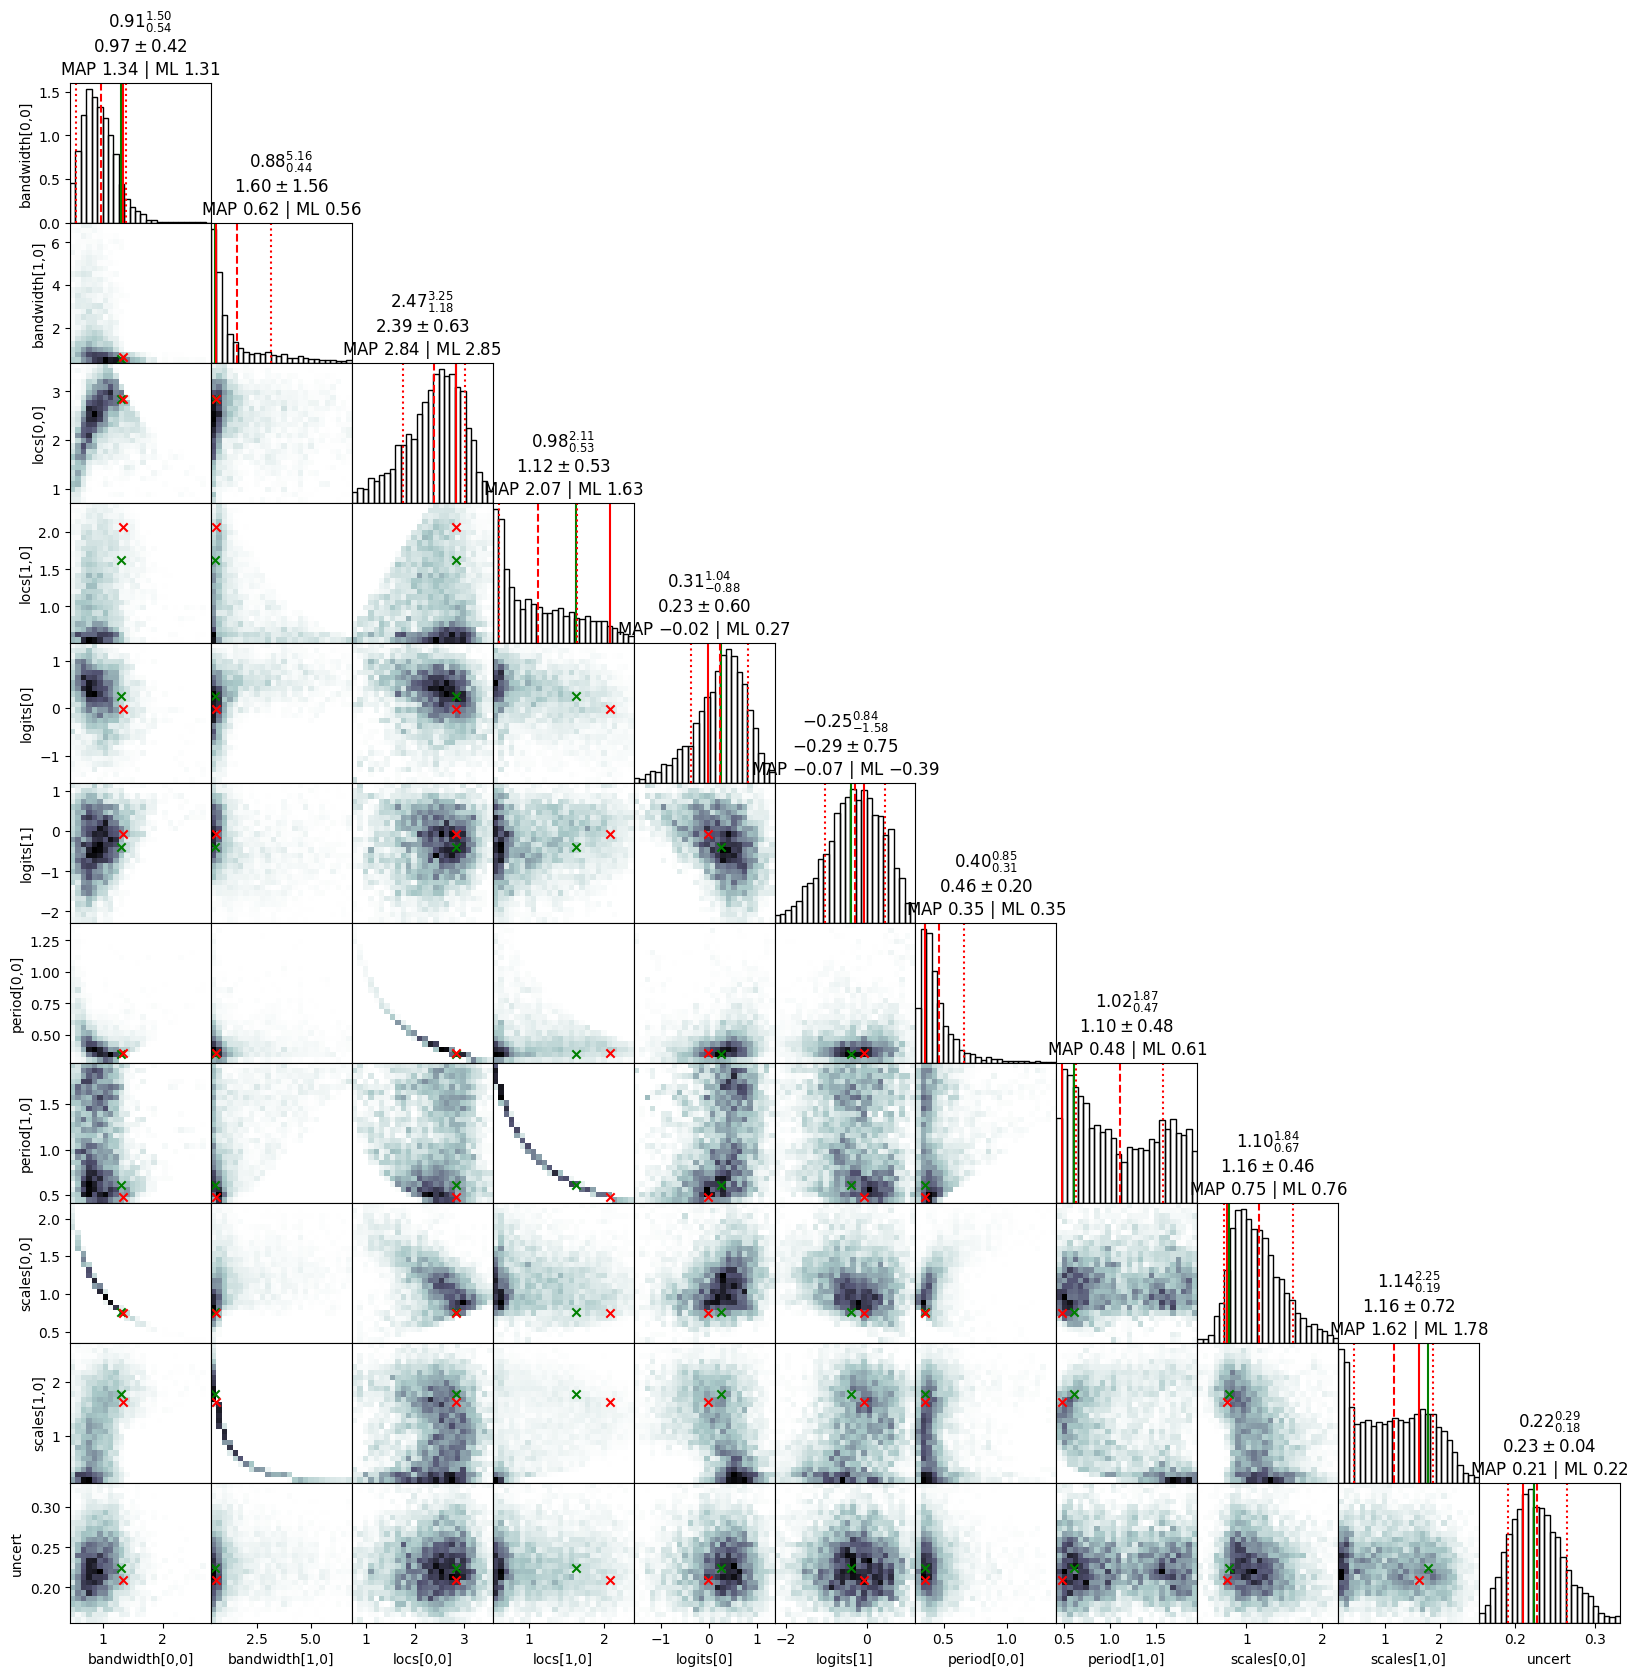

In [3]:


import jax
from jaxns import Prior, Model, DefaultNestedSampler

kernel = tfpk.SpectralMixture


def log_normal(x, mean, cov):
    L = jnp.linalg.cholesky(cov)
    # U, S, Vh = jnp.linalg.svd(cov)
    log_det = jnp.sum(jnp.log(jnp.diag(L)))  # jnp.sum(jnp.log(S))#
    dx = x - mean
    dx = solve_triangular(L, dx, lower=True)
    # U S Vh V 1/S Uh
    # pinv = (Vh.T.conj() * jnp.where(S!=0., jnp.reciprocal(S), 0.)) @ U.T.conj()
    maha = dx @ dx  # dx @ pinv @ dx#solve_triangular(L, dx, lower=True)
    log_likelihood = -0.5 * x.size * jnp.log(2. * jnp.pi) - log_det - 0.5 * maha
    return log_likelihood


def log_likelihood(uncert, kernel_params):
    """
    P(Y|sigma, half_width) = N[Y, f, K]
    Args:
        uncert: noise
        kernel_params: dict of kernel parameters
        
    Returns:
        log likelihood
    """
    K = tfpk.SpectralMixture(**kernel_params).matrix(X, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    mu = jnp.zeros_like(Y_obs)
    return log_normal(Y_obs, mu, K + data_cov)


# Build the model
n_components = 2


def prior_model():
    smallest_dt = jnp.min(jnp.diff(jnp.sort(X, axis=0), axis=0))  # d
    largest_dt = jnp.max(X, axis=0) - jnp.min(X, axis=0)  # d
    period = yield ForcedIdentifiability(n=2, low=smallest_dt, high=largest_dt, name='period')  # n, d
    locs = yield Prior(1. / period, name='locs')  # n, d
    max_bandwidth = (4. * period)  # n, d
    min_bandwidth = smallest_dt * 2
    bandwidth = yield Prior(
        tfpd.Uniform(min_bandwidth * jnp.ones_like(max_bandwidth), max_bandwidth * jnp.ones_like(max_bandwidth)),
        name='bandwidth')  # n, d
    scales = yield Prior(1. / bandwidth, name='scales')
    logits = yield Prior(tfpd.Normal(0. * jnp.ones(n_components), 1. * jnp.ones(n_components)), name='logits')  # n
    kernel_params = dict(locs=locs,
                         scales=scales,
                         logits=logits)
    uncert = yield Prior(tfpd.HalfNormal(0.2), name='uncert')
    return uncert, kernel_params


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

# Create the nested sampler class. In this case without any tuning.
exact_ns = DefaultNestedSampler(
    model=model,
    max_samples=1e6,
    parameter_estimation=True
)

termination_reason, state = jax.jit(exact_ns)(random.PRNGKey(42))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)

exact_ns.summary(results)
exact_ns.plot_diagnostics(results)
exact_ns.plot_cornerplot(results)


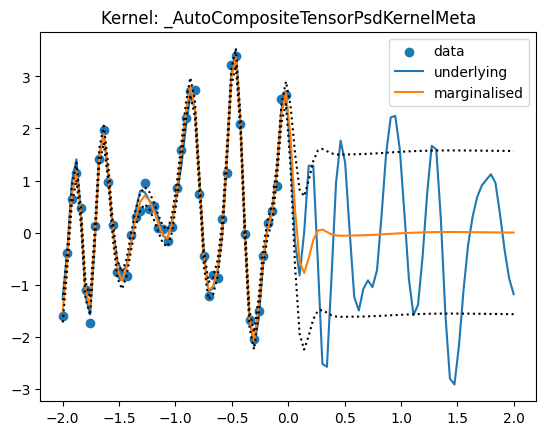

In [4]:
def predict_f_fn(uncert, locs, scales, logits):
    kernel_params = dict(locs=locs,
                         scales=scales,
                         logits=logits)
    Kxx = tfpk.SpectralMixture(**kernel_params).matrix(X, X)
    Ksx = tfpk.SpectralMixture(**kernel_params).matrix(Xstar, X)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    return Ksx @ jnp.linalg.solve(Kxx + data_cov, Y_obs)


def predict_fvar_fn(uncert, locs, scales, logits):
    kernel_params = dict(locs=locs,
                         scales=scales,
                         logits=logits)
    Kxx = tfpk.SpectralMixture(**kernel_params).matrix(X, X)
    Ksx = tfpk.SpectralMixture(**kernel_params).matrix(Xstar, X)
    Kss = tfpk.SpectralMixture(**kernel_params).matrix(Xstar, Xstar)
    data_cov = jnp.square(uncert) * jnp.eye(X.shape[0])
    return jnp.diag(Kss - Ksx @ jnp.linalg.solve(Kxx + data_cov, Ksx.T))


predict_f = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                results.ESS, predict_f_fn)

predict_fvar = marginalise_dynamic(random.PRNGKey(42), results.samples, results.log_dp_mean,
                                   results.ESS, predict_fvar_fn)

plt.scatter(X[:, 0], Y_obs, label='data')
plt.plot(Xstar[:, 0], Y, label='underlying')
plt.plot(Xstar[:, 0], predict_f, label='marginalised')
plt.plot(Xstar[:, 0], predict_f + jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.plot(Xstar[:, 0], predict_f - jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.title("Kernel: {}".format(kernel.__class__.__name__))
plt.legend()
plt.show()

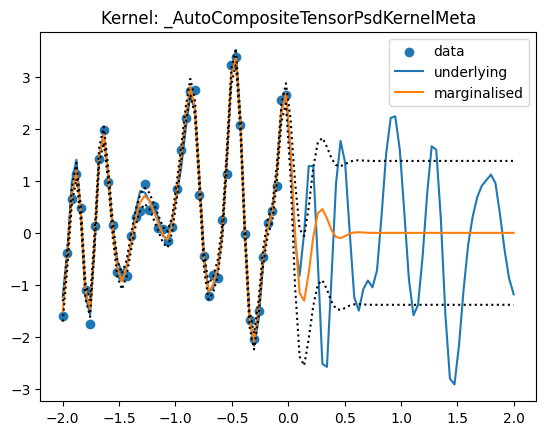

In [5]:
map_sample = maximum_a_posteriori_point(results)

predict_f = evaluate_map_estimate(results, predict_f_fn)

predict_fvar = evaluate_map_estimate(results, predict_fvar_fn)

plt.scatter(X[:, 0], Y_obs, label='data')
plt.plot(Xstar[:, 0], Y, label='underlying')
plt.plot(Xstar[:, 0], predict_f, label='marginalised')
plt.plot(Xstar[:, 0], predict_f + jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.plot(Xstar[:, 0], predict_f - jnp.sqrt(predict_fvar), ls='dotted',
         c='black')
plt.title("Kernel: {}".format(kernel.__class__.__name__))
plt.legend()
plt.show()